<a href="https://colab.research.google.com/github/diegomendes1/Classif-Express-Faciais/blob/main/Diego_Mendes_Classif_Express_Faciais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Expressões Faciais Utilizando Redes Neurais Convolucionais 
***Visão Computacional***
- Diego Mendes da Silva

OBS: o Data Augmentation foi feito em outro colab:
https://colab.research.google.com/drive/1SAhJIasWbKcJamMzIu0qn1wR70L6bv8M?usp=sharing

# Bibliotecas

In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
import glob
from PIL import Image

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import adam_v2
#from keras.optimizers import SGD
#from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
drive.mount('/content/drive')
pathData = '/content/drive/Shareddrives/Visão Computacional/Database/fer2013Original'

Mounted at /content/drive


# Base de Dados

In [ ]:
emotions = ["angry", "fear", "disgust", "happy", "sad", "surprise", "neutral"]
def GetEmotionName(id):
    return emotions[id]

def GetEmotionId(n):
    for i in range(len(emotions)):
        if emotions[i] == n: return i
    return -1

In [ ]:
def loadDataset(t):
    listImages = []
    listEmotions = []
    for emotion in emotions:
        print("carregando emotion: " + emotion)
        for filename in glob.glob(pathData + '/' + t + "/" + emotion + "/*.jpg"):
            im=Image.open(filename).resize((48, 48))
            listImages.append(np.array(im).astype("float32"))
            listEmotions.append(GetEmotionId(emotion))
        print("carregada: " + t + "/" + emotion)
    return (np.array(listImages), np.array(listEmotions))

In [ ]:
X_train, Y_train = loadDataset("train")
X_test, Y_test = loadDataset("test")

carregando emotion: angry
carregada: train/angry
carregando emotion: fear
carregada: train/fear
carregando emotion: disgust
carregada: train/disgust
carregando emotion: happy
carregada: train/happy
carregando emotion: sad
carregada: train/sad
carregando emotion: surprise
carregada: train/surprise
carregando emotion: neutral
carregada: train/neutral
carregando emotion: angry
carregada: test/angry
carregando emotion: fear
carregada: test/fear
carregando emotion: disgust
carregada: test/disgust
carregando emotion: happy
carregada: test/happy
carregando emotion: sad
carregada: test/sad
carregando emotion: surprise
carregada: test/surprise
carregando emotion: neutral
carregada: test/neutral


In [ ]:
X_train_norm = (X_train-127.)/127.
X_test_norm = (X_test-127.)/127.


Y_train_categ = keras.utils.to_categorical(Y_train)
Y_test_categ = keras.utils.to_categorical(Y_test)

# Modelos
O modelo utilizado está na primeira função, pois é chamado quando dropout > 0

In [ ]:
def getModelDropout(dropout):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(SpatialDropout2D(dropout))

  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(SpatialDropout2D(dropout))

  model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))

  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(7, activation='softmax'))
  return model

In [ ]:
def getModelBatchNormalization(dropout=0.3):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(7, activation='softmax'))
  return model

In [ ]:
def CalcularModelo(lr, lrDecay, batchSize, dropout, numEpochs = 20):
  novoModelo = None
  if(dropout == 0):
    novoModelo = getModelBatchNormalization()
  else:
    novoModelo = getModelDropout(dropout)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

  novoModelo.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=lr, decay=lrDecay),metrics=['accuracy'])
  infoModelo = novoModelo.fit(
    X_train_norm,
    Y_train_categ,
    steps_per_epoch = len(X_train_norm) // batchSize,
    epochs = numEpochs,
    verbose = 1,
    validation_data = (X_test_norm, Y_test_categ),
    callbacks=[reduce_lr]
  )
  return infoModelo

# Treinamento

In [ ]:
lr = 0.0001
lrd = 1e-6
bs = 32
dr = 0.50

model_info = CalcularModelo(lr, lrd, bs, dr, 50)

Epoch 1/50
897/897 [==============================] - 71s 78ms/step - loss: 1.6967 - accuracy: 0.3221 - val_loss: 1.5351 - val_accuracy: 0.3996 - lr: 1.0000e-04
Epoch 2/50
897/897 [==============================] - 70s 78ms/step - loss: 1.4694 - accuracy: 0.4359 - val_loss: 1.3349 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 3/50
897/897 [==============================] - 70s 78ms/step - loss: 1.3518 - accuracy: 0.4832 - val_loss: 1.2419 - val_accuracy: 0.5222 - lr: 1.0000e-04
Epoch 4/50
897/897 [==============================] - 70s 78ms/step - loss: 1.2652 - accuracy: 0.5197 - val_loss: 1.1886 - val_accuracy: 0.5485 - lr: 1.0000e-04
Epoch 5/50
897/897 [==============================] - 70s 78ms/step - loss: 1.1957 - accuracy: 0.5475 - val_loss: 1.1449 - val_accuracy: 0.5649 - lr: 1.0000e-04
Epoch 6/50
897/897 [==============================] - 71s 79ms/step - loss: 1.1410 - accuracy: 0.5707 - val_loss: 1.0988 - val_accuracy: 0.5847 - lr: 1.0000e-04
Epoch 7/50
897/897 [==============

# Gráficos

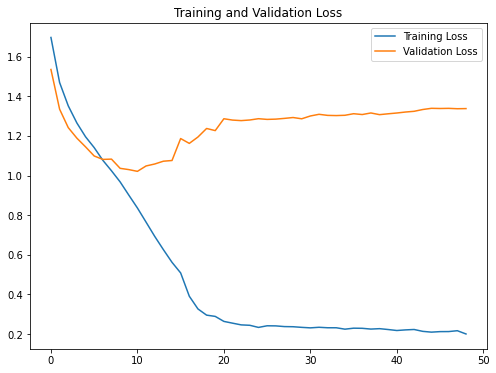

In [ ]:
acc = model_info.history['accuracy']
val_acc = model_info.history['val_accuracy']

loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('bestModelGraph.png')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Acurácia(%)')
ax.set_xlabel('Taxa de Aprendizagem')
ax.set_title('Taxa de Aprendizagem x Acurácia')
plt.ylim(55, 65)
ax.bar(vals,accuracy)
plt.show()

In [ ]:
plt.subplot(1, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('bestModelGraph.png')
plt.show()

In [ ]:
#model.save(pathData)